# Bigram For Name Generation

Bigram is a primative character-level Language Model. Given a character it will predict the next character - hence Bi. We dont consider the whole sentence, its only local; given the previous one character how likely is next. Likely will just be given by the frequency of pairs of characters seen in the training set.

In [104]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns

In [105]:
names = open("names.txt", "r").read().splitlines()

In [106]:
names[0]

'emma'

## Create Bigram

* create the pairs of characters for each name
* add start, end indicator token "."
* create a dict of the bigram counts
* Convert bigram from dict to 2D Tensor with shape (vocab, vocab) - need a mapping from char to index and vice versa

In [107]:
bigram_dict = {}

#pair characters in each name
for name in names:
    #add start end token
    chs = ["."] + list(name) + ["."]

    for ch1, ch2 in zip(chs, chs[1:]): # nice trick, name='emma' name[1:]='mma' (which is shorter). zip when reaches end stops!
       bigram_dict[(ch1, ch2)] = bigram_dict.get((ch1, ch2), 0) + 1

In [108]:
vocab = sorted(list(set(''.join(names)))) #concate all names together, throw dup, convert to list and sort
vocab.insert(0, ".") #insert our start and end indicator token at the start of our vocab
vocab

['.',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

In [109]:
#mapping for characters to idx in bigram table
char_to_idx = {char:idx for idx, char in enumerate(vocab)}
idx_to_char = {idx:char for idx, char in enumerate(vocab)}

In [110]:
bigram_tensor = torch.zeros([len(vocab), len(vocab)], dtype=torch.int32)

#iterate through each bigram pair and update that location in the tensor with the count
for (ch1, ch2), count in bigram_dict.items():
    idx1, idx2 = char_to_idx[ch1], char_to_idx[ch2]
    bigram_tensor[idx1, idx2] = count


In [111]:
bigram_tensor[:3,:3]

tensor([[   0, 4410, 1306],
        [6640,  556,  541],
        [ 114,  321,   38]], dtype=torch.int32)

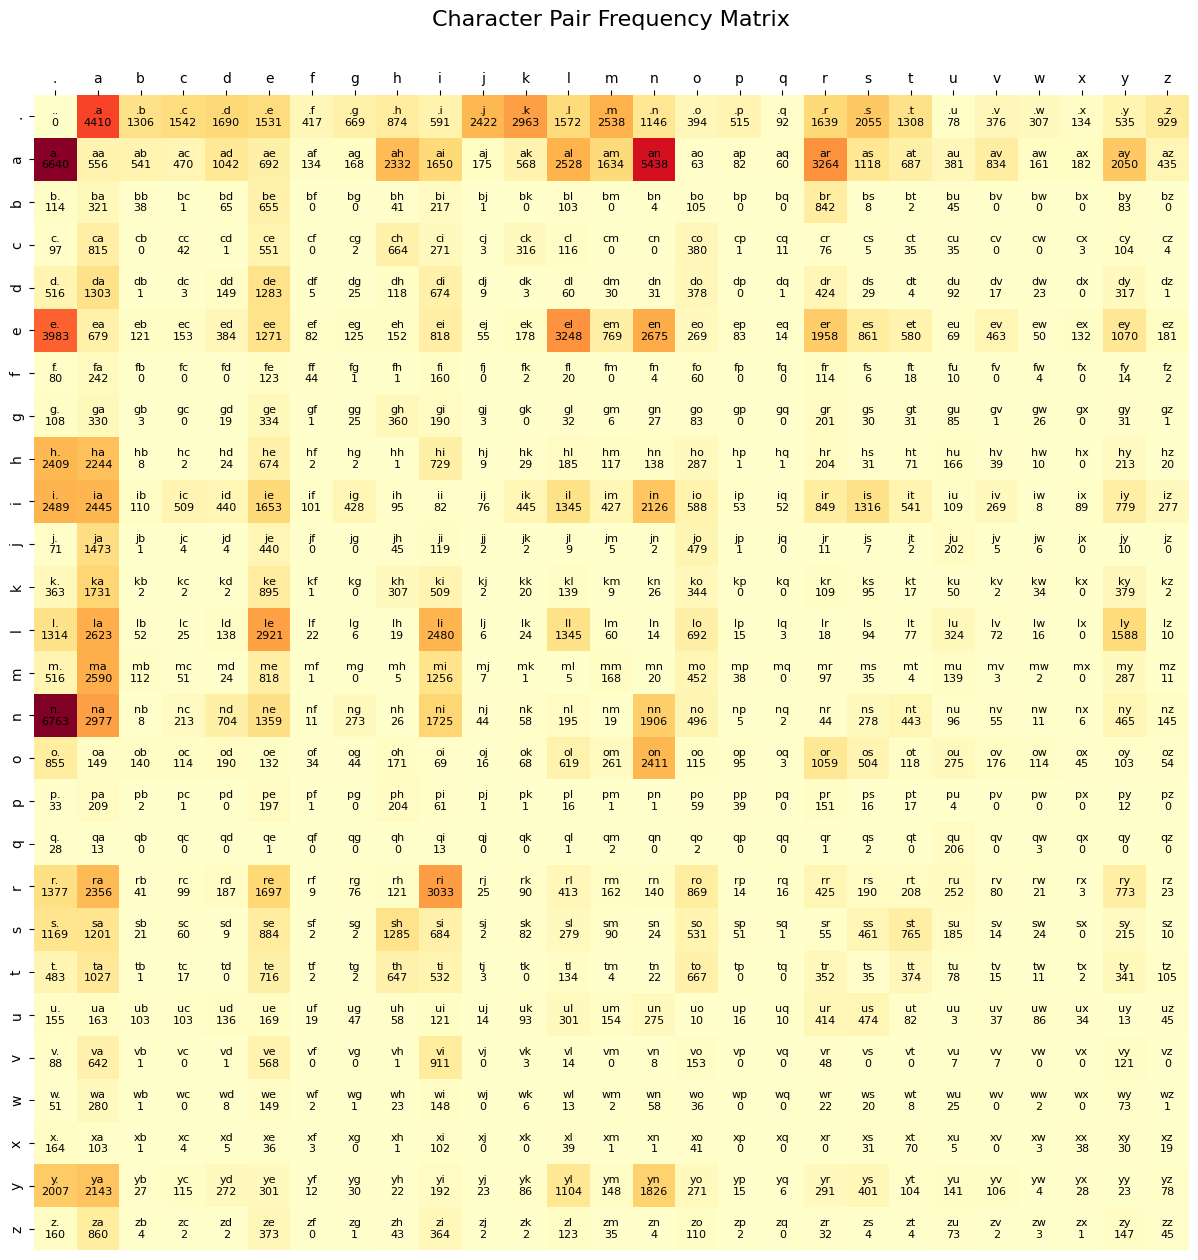

In [112]:
# Create the plot
plt.figure(figsize=(15, 15))
ax = sns.heatmap(bigram_tensor, annot=False, cmap='YlOrRd', square=True, cbar=False, xticklabels=vocab, yticklabels=vocab)

# Add character pairs to each cell
for i in range(len(vocab)):
    for j in range(len(vocab)):
        plt.text(j + 0.5, i + 0.5, f"{vocab[i]}{vocab[j]}\n{bigram_tensor[i, j]}",
                 ha='center', va='center', fontsize=8)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
plt.title("Character Pair Frequency Matrix", fontsize=16, pad=50)
plt.show()

Each row represents a the frequency distribution of a character following a previous character. The way we will prodcue new names is through sampling from a probability distribution of the frequencies.

In [113]:
# create probability dist by normalising each row by its sum

# `keepdim`` is cruitial here -> we want row sums so dont want to squeeze the column dim out. keep as a col vector
P = bigram_tensor.float()
P /= bigram_tensor.sum(dim=1, keepdim=True) #inplace divison means no new memory is created! (More efficent)
P

tensor([[0.0000e+00, 1.3767e-01, 4.0770e-02, 4.8138e-02, 5.2758e-02, 4.7794e-02,
         1.3018e-02, 2.0885e-02, 2.7284e-02, 1.8450e-02, 7.5610e-02, 9.2498e-02,
         4.9074e-02, 7.9231e-02, 3.5776e-02, 1.2300e-02, 1.6077e-02, 2.8720e-03,
         5.1166e-02, 6.4153e-02, 4.0833e-02, 2.4350e-03, 1.1738e-02, 9.5839e-03,
         4.1832e-03, 1.6702e-02, 2.9001e-02],
        [1.9596e-01, 1.6408e-02, 1.5966e-02, 1.3870e-02, 3.0751e-02, 2.0422e-02,
         3.9546e-03, 4.9579e-03, 6.8821e-02, 4.8694e-02, 5.1645e-03, 1.6763e-02,
         7.4605e-02, 4.8222e-02, 1.6048e-01, 1.8592e-03, 2.4199e-03, 1.7707e-03,
         9.6326e-02, 3.2994e-02, 2.0274e-02, 1.1244e-02, 2.4613e-02, 4.7514e-03,
         5.3711e-03, 6.0499e-02, 1.2838e-02],
        [4.3100e-02, 1.2136e-01, 1.4367e-02, 3.7807e-04, 2.4575e-02, 2.4764e-01,
         0.0000e+00, 0.0000e+00, 1.5501e-02, 8.2042e-02, 3.7807e-04, 0.0000e+00,
         3.8941e-02, 0.0000e+00, 1.5123e-03, 3.9698e-02, 0.0000e+00, 0.0000e+00,
         3.1834e-

Here we have the probability (across each row) of a character in our vocab occuring after a certain character. so for example the 1st row represents the the prob dist of a char in our vocab occuring after the start/end character i.e. its the probabilty a name starts with that character e.g. prob a name starts with a (i.e. ".a") is 0.13.

Key Observation here is we need a `Multi-nomial Distribution`. each character can be modelled as a binomial dist with a probabilty of success. (e.g. prob of success of "a" starting a name is 0.13, so we have a 13% chance of drawing an "a"). A multi-nomial distribution models the probabilities of multiple catagories in a single trial (so where binomial is success/failure (bi), the multi-nomial has multiple outcomes (k1, k2, k3, ...) hence multi). So we feed in the probability of each character occuring, we can then sample from this dist, and it will return the index of the selected category. The best way to imagine this is a weighted dice. in our case we have a 27 sided dice, which is weighted accoring to the probabilities, so high prob gives high weighting and hence more likely to roll it. A trail/sample is a roll of this dice, where the dice lands gfives the index of our vocab! 

In [114]:
#create new words
# here we are providing the prob of the first character in the name and 
# asking for the `dice` to be rolled (distribution to be sampled 10 times).
# replacement=True means the index can occur again (if this was false we could only roll len(vocab) times!)
torch.multinomial(P[0, :], 10, replacement=True)

tensor([ 3,  3, 11, 19,  1, 19, 10,  5, 11,  7])

### Generate Words

In [115]:
CREATE_NUM_NAMES=3
#create CREATE_NUM_NAMES
for i in range(CREATE_NUM_NAMES):
    ix=0 #start at our start/end indicator (start since its at the start)
    out = [] #store our words

    while True:
        probs = P[ix] #select the prob dist associated with that char. idx=0 is prob dist where "." starts

        #sample the next character and store
        ix = torch.multinomial(probs, num_samples=1, replacement=True).item()
        out.append(idx_to_char[ix])
        
        #continue sampling untill characters untill we reach our end character "."
        if ix == 0: 
            break
        
    print("".join(out))


ss.
amahemake.
an.


### Model Evaluation

The goal of our bigram model is to maximise the probabilities of the correct bigrams in our **training data**. We want to assign higher probabilities to the bigrams that actually appear in our training data and likewise assign lower probablities to those that dont appear that often or at all. Our bigram model is limited because it doesnt have the capapiblity to be iteratively trainined (they learn by estimating probabilities based on observed frequencies), but in future models such as transformers where we can train and thus learn longer and more complex patterns (hence assign better probabilites) having a performance metric is cruital not only for training the model (goal being to lower the loss) but to compare different model performances!

To measure performance, we measure how well the model assigns probabilities. A model is "good" if it assigns a higher probability to bigrams that are more likely to occur and likewise a "poor" model is one that doesnt (i.e. it assigns high probability to bigrams that dont occur often or at all or low prob to those that do)

The bigram has learnt! If we assign equal probability to each character occuring given a previous character, we get 1/len(vocab) = 1/27 ~= 0.4 (or 4%). If we explore the Probability matrix we see that the probabilities differ! It has "learnt" (through counting the frequencies) to assign less probability to some chara and higher probability to others!

In [116]:
P[0]

tensor([0.0000, 0.1377, 0.0408, 0.0481, 0.0528, 0.0478, 0.0130, 0.0209, 0.0273,
        0.0184, 0.0756, 0.0925, 0.0491, 0.0792, 0.0358, 0.0123, 0.0161, 0.0029,
        0.0512, 0.0642, 0.0408, 0.0024, 0.0117, 0.0096, 0.0042, 0.0167, 0.0290])

#### How do we measure how "good" the model is?

Again the model is "good" if it assign high probability to bigrams that are likely to occur in our training data. So a measure of performance is to take the likelihood. The likelhood is the product of all the bigram probabilities


**Intuition behind Likelihood**

Think of likelihood as answering the question "How likely is it that our model would generate this exact sequence of characters?". It represents how well the model predicts the observed data. A good model will assign high probability to bigrams that actually occur in the language. We are assuming **conditional independence a.k.a Markov Assumption** of events. Bigram models are based on the Markov assumption, specifically a first-order Markov model. This assumes that the probability of a character depends only on the previous character, not on any earlier history of characters.

NOTE: We need conditional independence rather than full independence because we need a way of preserving the sequential nature of characters. if we had true independence then P("matt") = P(m)P(a)P(t)P(t) = P(t)P(a)P(m)P(t)

e.g. Suppose we have the name "matt". The model breaks this into the bigrams ".m" "ma" "at" "tt" "t." The probability that our model predicts "matt" is:

P(".m" and "ma" and "at" and "tt" and "t.") = P(m|.)P(a|m)P(t|a)P(t|t)P(.|t) [since we are assuming conditional indpendence - which is correct since the probability of the current character depends only on the previous character (not any further history of characters) i.e. in our bigram model P(t|ma) = P(t|a) because our model doesnt consider anything other than the previous charaxter]

In [117]:
# Lets examine some of the probailities of bigrams
likelihood = torch.tensor(1.0)
log_likelihood = torch.tensor(1.0)
counter = 1
for (ch1, ch2), count in bigram_dict.items():

    if counter == 13:#1st and 2nd name in our dataset
        break
    idx1, idx2 = char_to_idx[ch1], char_to_idx[ch2]
    bigram_prob = P[idx1, idx2]
    print(f"{ch1}{ch2}  {bigram_prob:.4f}")
    likelihood *= bigram_prob
    log_likelihood += torch.log(bigram_prob) #log(abc) = log(a) + log(b) + log(c)
    counter +=1
#The likelihood is the product of all these probabilities
print("")
print(f"Likehood: {likelihood}")
print(f"log Likelihood: {log_likelihood}")
print(f"Negative Log Likeihood: {-log_likelihood}")
print(f"Average Negative Log Likelihood: {-log_likelihood/counter}")

.e  0.0478
em  0.0377
mm  0.0253
ma  0.3899
a.  0.1960
.o  0.0123
ol  0.0780
li  0.1777
iv  0.0152
vi  0.3541
ia  0.1381
.a  0.1377

Likehood: 6.067879759850264e-14
log Likelihood: -29.433181762695312
Negative Log Likeihood: 29.433181762695312
Average Negative Log Likelihood: 2.2640910148620605


If we were able to iteratively train our model our Goal would be to maximise the likelihood w.r.t the model parameters, which in this case are the bigram probabilities (we could tweak say prob of "em" a little bit and if would influence the end likelihood). Why maximise? well each probability is between [0, 1], where 1 represents certainty for the next character. (However this is in reality impossible for a bigram model since we are considering frequencies, so if we wanted to predict the name emma, which is made up of "mm" and "ma" we couldnt have probability of 1 for each.) But theoretically the perfect model (since we will consider other models in future not just bigrams) would have a likelihood of 1, where each transition in a sequence has a probility of 1. So we want to get as close to 1 as possible. So likelihood ranges from [0, 1], with 1 being perfect model.

Maximising the likelihood is equivelent to maximising the log likelihood (since log is a monotonic function). we consider log because its mathematically nicer to work with (it turns products into sums log(abc) = log(a)+log(b)+log(c) and doesnt change the location of the optimum) and also gives us better numbers to work with (rather than multiplying decimals) which prevent "underflow" in computer optimisation. log(0)=-inf and log(1)=0. The more negative the log likelihood is, the worst it is.

Maximising the log Likelihood is equivelent to minimising the negative log likelihood ve-log(0)=inf and ve-log(1)=0.7. We can take an average to give us the average negative log likelihood.

Hence our goal is to minimise the (average) negative log likelihood (with zero representing a Theoretically perfect Model)

### Model Smoothing

In [118]:
#consider the following
likelihood = torch.tensor(1.0)
log_likelihood = torch.tensor(1.0)
counter = 1

for char in ["mattk"]: #add a k to see inf
    chars = ["."] + list(char) + ["."]
    for ch1, ch2 in zip(chars, chars[1:]):

        idx1, idx2 = char_to_idx[ch1], char_to_idx[ch2]
        bigram_prob = P[idx1, idx2]
        likelihood *= bigram_prob
        log_likelihood += torch.log(bigram_prob) #log(abc) = log(a) + log(b) + log(c)
        print(f"{ch1}{ch2} --> {bigram_prob}")
        counter +=1
        
print("")
print(f"Likehood: {likelihood}")
print(f"log Likelihood: {log_likelihood}")
print(f"Negative Log Likeihood: {-log_likelihood}")
print(f"Average Negative Log Likelihood: {-log_likelihood/counter}")      

.m --> 0.07923079282045364
ma --> 0.38994279503822327
at --> 0.020274458453059196
tt --> 0.06714542210102081
tk --> 0.0
k. --> 0.07202380895614624

Likehood: 0.0
log Likelihood: -inf
Negative Log Likeihood: inf
Average Negative Log Likelihood: inf


The reason we see no likelihood is because the bigram "tk" never occured and since log(0)=-inf, we get inf's. To avoid this we can introduce **Model Smoothing** by which we initalise with ones (i.e. all bigrams start with one count - then we train (i.e. count all frequencies in trading data))

In [119]:
smoothed_P = bigram_tensor.float() + 1
smoothed_P /= bigram_tensor.sum(dim=1, keepdim=True) #inplace divison means no new memory is created! (More efficent)

In [120]:
#consider the following
likelihood = torch.tensor(1.0)
log_likelihood = torch.tensor(1.0)
counter = 1

for char in ["mattk"]: #add a k to see inf
    chars = ["."] + list(char) + ["."]
    for ch1, ch2 in zip(chars, chars[1:]):

        idx1, idx2 = char_to_idx[ch1], char_to_idx[ch2]
        bigram_prob = smoothed_P[idx1, idx2]
        likelihood *= bigram_prob
        log_likelihood += torch.log(bigram_prob) #log(abc) = log(a) + log(b) + log(c)
        print(f"{ch1}{ch2} --> {bigram_prob:.4f}")
        counter +=1
        
print("")
print(f"Likehood: {likelihood}")
print(f"log Likelihood: {log_likelihood}")
print(f"Negative Log Likeihood: {-log_likelihood}")
print(f"Average Negative Log Likelihood: {-log_likelihood/counter}")  

.m --> 0.0793
ma --> 0.3901
at --> 0.0203
tt --> 0.0673
tk --> 0.0002
k. --> 0.0722

Likehood: 5.480325637741146e-10
log Likelihood: -20.32468605041504
Negative Log Likeihood: 20.32468605041504
Average Negative Log Likelihood: 2.903526544570923


Now rather than having zero probability and hence causing zero likelihood, we have a very small probaility (0.0002=1/sum(t row)).

Another important point: what happens when i increase the value we initalise with, say 1,000,000. well the probility distributions become uniform, since if say the max count is 500. well 1,000,000 compared to 1,000,500 is not alot when we then normalise which leads to probabilities that all roughly the same.  

#### Final loss

In [144]:
bigram_tensor = torch.zeros([len(vocab), len(vocab)], dtype=torch.int32)

#iterate through each bigram pair and update that location in the tensor with the count
for (ch1, ch2), count in bigram_dict.items():
    idx1, idx2 = char_to_idx[ch1], char_to_idx[ch2]
    bigram_tensor[idx1, idx2] = count

In [147]:
P = bigram_tensor.float() + 1. #add smoothing
P /= bigram_tensor.sum(dim=1, keepdim=True) #inplace divison means no new memory is created! (More efficent)
P

tensor([[3.1218e-05, 1.3770e-01, 4.0802e-02, 4.8169e-02, 5.2789e-02, 4.7826e-02,
         1.3049e-02, 2.0916e-02, 2.7316e-02, 1.8481e-02, 7.5641e-02, 9.2530e-02,
         4.9106e-02, 7.9262e-02, 3.5807e-02, 1.2331e-02, 1.6108e-02, 2.9033e-03,
         5.1197e-02, 6.4184e-02, 4.0864e-02, 2.4662e-03, 1.1769e-02, 9.6151e-03,
         4.2144e-03, 1.6733e-02, 2.9033e-02],
        [1.9599e-01, 1.6438e-02, 1.5995e-02, 1.3900e-02, 3.0781e-02, 2.0452e-02,
         3.9841e-03, 4.9875e-03, 6.8851e-02, 4.8724e-02, 5.1940e-03, 1.6792e-02,
         7.4635e-02, 4.8251e-02, 1.6051e-01, 1.8887e-03, 2.4495e-03, 1.8002e-03,
         9.6355e-02, 3.3023e-02, 2.0304e-02, 1.1273e-02, 2.4642e-02, 4.7809e-03,
         5.4006e-03, 6.0528e-02, 1.2867e-02],
        [4.3478e-02, 1.2174e-01, 1.4745e-02, 7.5614e-04, 2.4953e-02, 2.4802e-01,
         3.7807e-04, 3.7807e-04, 1.5879e-02, 8.2420e-02, 7.5614e-04, 3.7807e-04,
         3.9319e-02, 3.7807e-04, 1.8904e-03, 4.0076e-02, 3.7807e-04, 3.7807e-04,
         3.1871e-

In [151]:
# Lets examine some of the probailities of bigrams
likelihood = torch.tensor(1.0)
log_likelihood = torch.tensor(0.0)
counter = 0
for name in names:
    name = ["."] + list(name) + ["."]
    for ch1, ch2 in zip(name, name[1:]):

        idx1, idx2 = char_to_idx[ch1], char_to_idx[ch2]
        bigram_prob = P[idx1, idx2]
        likelihood *= bigram_prob
        log_likelihood += torch.log(bigram_prob) #log(abc) = log(a) + log(b) + log(c)
        counter +=1
#The likelihood is the product of all these probabilities
print("")
print(f"Likehood: {likelihood}")
print(f"log Likelihood: {log_likelihood}")
print(f"Negative Log Likeihood: {-log_likelihood}")
print(f"Average Negative Log Likelihood: {-log_likelihood/counter}")


Likehood: 0.0
log Likelihood: -559322.6875
Negative Log Likeihood: 559322.6875
Average Negative Log Likelihood: 2.4515998363494873


# Utalise a Neural Network to learn the "best" bigram probabilities for our Training Dataset

In the bigram model we counted the frequency of each bigram, normalised these over the row (i.e. over the array with the same starting characters) and ended-up with a probabilty distribution for the next character given the previous. We fed this prob dist into a `.multinomal()` which we could then sample from. The index from the multinomial represented the next predicted characters. names were iteratively built by continuted sampling based on previous character untill we drew the "." (start/end indicator) character.

Now we would like to build a Neural Network (NN) to "learn" the prob dist for a next character, given a previous character. (i.e. rather than counting the frequencies and establishing a prob dist). 1st step is to define our inputs and outputs, the fundamental advantage to NN is we decide what the inputs are and what we interprete the output as. Then with enough data the NN learns the right weight for our needs (we give it examples it predicts we define how wrong it is, it adjusts and trys again).

**INPUT**: 1-hot encoded vector, representing the index in our vocab of the 1st character (i.e. for bigram "em" its "e")

**OUPUT**: A vector of length 27 which represents the prob-dist of the 2nd character given the 1st character (input)

In [122]:
#transform data into inputs (1st char) and targets (predicted next char given the 1st char) 
xs, ys = [], []

for name in names[:1]:
    #add start end token
    chs = ["."] + list(name) + ["."]

    for ch1, ch2 in zip(chs, chs[1:]):
        x, y = char_to_idx[ch1], char_to_idx[ch2]
        xs.append(x)
        ys.append(y)
xs = torch.tensor(xs)
ys = torch.tensor(ys)

In [123]:
xs

tensor([ 0,  5, 13, 13,  1])

In [124]:
ys

tensor([ 5, 13, 13,  1,  0])

In the name ".emma." we have **five** example bigrams: `[.->e, e->m, m->m, m->a, a->.]` which gives xs = `[., e, m, m, a]` and targets (Correct next char), ys, = `[e, m, m, a, .]`. Converting these to there index gives us `[0, 5, 13, 13, 1]` and `[5, 13, 13, 1, 0]`. so 0->5, 5->13, ...

However we cant feed integers into a neural network because there is no meaning to the distance between integers (they represent categories) but a neural network doesnt know that and can assign more weight (i.e. importance) to larger integers, which can lead to bias in training. So the appropriate step is to **One-Hot Encode** (i.e. placing a 1 in the index and zeros elsewhere) firsty it makes the categorical nature much clearer to the network, it allows for equal treatment by the network since the euclian distance between any two features, is the same (i.e. sqrt(2)) so there will be no assumptions on some categories being more similar to each other than other, theyre all as similar as each other, no bias.

In [125]:
import torch.nn.functional as F

#f.one_hot() returns a "Long"tensor i.e. a tensor of int's. call float method
xenc = F.one_hot(xs, num_classes=len(vocab)).float()
xenc

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [126]:
xenc.shape #5, 27 -> 5 examples (1st char) and 27 is the length of vocab (i.e. "." is zero index in our vocab of len 27, so 1 in 1st index)

torch.Size([5, 27])

In [127]:
# We need to choose weights such that the output is of length 27 (representing a prob dist over our vocab for the 2nd chara given the 1st char)
# first dim of the weight must equal the last dim of the inputs (in order to comput the dot product)
# the last dim of the weights will be the size of the last output dim

#sampled from random normal(0, 1) so some ve+ some ve- most around zero, very few above 3 or below -3
W = torch.randn((27, 27), requires_grad=True) # require_grad=True to allow pytorch to conduct the backwards pass and store gradients in this tensor!

In [128]:
#input layer x 1st (linear) layer --> 5,27 x 27, 27 ==> 5, 27 
# which we will interpret (after some transforms) as 5 seperate prob dist given the five 1st char inputs
# logits are the raw values before any activations are applied (i.e. just the dot product of weights and inputs)
logits = xenc @ W
logits.shape

torch.Size([5, 27])

In [129]:
#############
## Softmax ##
#############
#(convert vector into prob dist)
#logits can be seen as log(counts)
#exp(logits) ==> counts
counts = logits.exp()
#normalise the counts to give us a prob dist
prob_dists = counts / counts.sum(1, keepdim=True)

In [130]:
prob_dists

tensor([[0.0191, 0.0188, 0.0688, 0.0420, 0.0500, 0.0126, 0.0818, 0.0266, 0.0356,
         0.0099, 0.0152, 0.0764, 0.0139, 0.0304, 0.0138, 0.0253, 0.0344, 0.0283,
         0.0124, 0.0144, 0.0263, 0.0148, 0.0868, 0.0629, 0.0552, 0.0143, 0.1100],
        [0.1138, 0.0203, 0.0766, 0.0345, 0.0362, 0.0086, 0.0158, 0.0074, 0.0575,
         0.0108, 0.0427, 0.0048, 0.1490, 0.0093, 0.0074, 0.0080, 0.0107, 0.0155,
         0.0788, 0.0339, 0.0212, 0.0263, 0.0207, 0.0526, 0.1181, 0.0114, 0.0078],
        [0.0536, 0.1457, 0.0181, 0.0154, 0.0393, 0.0644, 0.0108, 0.0265, 0.0125,
         0.0773, 0.0164, 0.0474, 0.0489, 0.0344, 0.0149, 0.0151, 0.0126, 0.0277,
         0.0248, 0.0477, 0.0114, 0.0098, 0.0513, 0.0228, 0.1152, 0.0103, 0.0259],
        [0.0536, 0.1457, 0.0181, 0.0154, 0.0393, 0.0644, 0.0108, 0.0265, 0.0125,
         0.0773, 0.0164, 0.0474, 0.0489, 0.0344, 0.0149, 0.0151, 0.0126, 0.0277,
         0.0248, 0.0477, 0.0114, 0.0098, 0.0513, 0.0228, 0.1152, 0.0103, 0.0259],
        [0.0164, 0.0375,

In [131]:
prob_dists[0].sum()

tensor(1., grad_fn=<SumBackward0>)

In [132]:
# we are computing the negative log likelihood. The likelihood was the product of all the bigram probabilities
#considering our 1st word only ys=tensor([ 5, 13, 13,  1,  0]), these are the indexes of the prob dists (they represent the (true) next chara)
# so we want these to be as high as possible. the 1st prob dist (out of 5, in this case) we want the 5th indexed characters probability,
#similarly we want the 13th indexed character in the 2nd prob dist (out of the 5 in this example)

# we want the avergae negative log likelihood
loss =  -prob_dists[torch.arange(5), ys].log().mean()
loss

tensor(3.6917, grad_fn=<NegBackward0>)

In [133]:
#backwards pass
W.grad = None #set to none to let pytroch know we havent computed any gradients yet
loss.backward()

pytorch is able to (in the background) build the computational graph of the forward pass, including all mathematical operations. When we call loss.backwards() pytorch is able to back propogate the gradients all the way to our weight (parameter) matrix. So now we see that W.grad has gone for all Nones to values! 

In [134]:
W.grad

tensor([[ 0.0038,  0.0038,  0.0138,  0.0084,  0.0100, -0.1975,  0.0164,  0.0053,
          0.0071,  0.0020,  0.0030,  0.0153,  0.0028,  0.0061,  0.0028,  0.0051,
          0.0069,  0.0057,  0.0025,  0.0029,  0.0053,  0.0030,  0.0174,  0.0126,
          0.0110,  0.0029,  0.0220],
        [-0.1967,  0.0075,  0.0071,  0.0025,  0.0041,  0.0160,  0.0171,  0.0089,
          0.0065,  0.0048,  0.0355,  0.0032,  0.0026,  0.0015,  0.0102,  0.0024,
          0.0038,  0.0009,  0.0014,  0.0022,  0.0099,  0.0095,  0.0022,  0.0029,
          0.0063,  0.0027,  0.0252],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000

reminder of what these gradients represent. These are the gradients of the loss function w.r.t the weights. We want these because it tells us how much tweaking a weight will affect the loss. So if a grad of loss w.r.t say weight 1 is 0.0235, this is telling us that the gradient is positive, meaning if we increase the weight by a little bit the loss will also increase

In [135]:
#update the weight W[0,0] (which has a postive grad of 0.0035)

W.data[0,0] += 3.

In [136]:
#running the forward pass...
logits = xenc @ W
counts = logits.exp()
prob_dists = counts / counts.sum(1, keepdim=True)
loss =  -prob_dists[torch.arange(5), ys].log().mean()
loss

tensor(3.7537, grad_fn=<NegBackward0>)

As you can see the loss has increased from 3.4426 to 3.4998 

### Full pass

In [137]:
#forward Pass
logits = xenc @ W
counts = logits.exp()
prob_dists = counts / counts.sum(1, keepdim=True)
loss =  -prob_dists[torch.arange(5), ys].log().mean()
loss.item()

3.7537007331848145

In [138]:
#backward pass - compute the gradients of the loss w.r.t weights
W.grad = None
loss.backward()

In [139]:
#update - the weights in the direction that reduces the loss (ve- dirn)
W.data += -0.1 * W.grad

In [140]:
#if we now go back and recalculate the forward pass (on the new weight values) we get a loss that slightly smaller - this is grad descent!

### Full Gradient Descent

In [141]:
#transform data into inputs (1st char) and targets (predicted next char given the 1st char) 
xs, ys = [], []

for name in names:
    #add start end token
    chs = ["."] + list(name) + ["."]

    for ch1, ch2 in zip(chs, chs[1:]): #create bigrams .emma. ==> (., e), (e, m), (m, m), (m, a), (m, .) [5 examples in the word emma]
        
        # map character to index in vocab
        x, y = char_to_idx[ch1], char_to_idx[ch2]
        xs.append(x)
        ys.append(y)
xs = torch.tensor(xs)
ys = torch.tensor(ys)

print(f"Number of bigrams: {xs.nelement()}")

#create one-hot encoding of x 
xenc = F.one_hot(xs, num_classes=len(vocab)).float()
W = torch.randn((27,27), requires_grad=True) #tell torch that we'll want to compute the gradients and keep track of the comp graph

Number of bigrams: 228146


In [142]:
#gradient decent loop

number_of_iterations = 100

for i in range(number_of_iterations):

    #forward pass
    logits = xenc @ W
    counts = logits.exp()
    prob_dists = counts / counts.sum(1, keepdim=True)
    loss =  -prob_dists[torch.arange(ys.shape[0]), ys].log().mean() #number of elements 
    print(f"loss: {loss.item():.4f}")

    #backward pass
    W.grad = None #
    loss.backward()

    #update the weights based on the gradient info
    W.data += -50 * W.grad


loss: 3.8119
loss: 3.4260
loss: 3.1963
loss: 3.0486
loss: 2.9448
loss: 2.8682
loss: 2.8105
loss: 2.7662
loss: 2.7315
loss: 2.7036
loss: 2.6810
loss: 2.6622
loss: 2.6464
loss: 2.6329
loss: 2.6212
loss: 2.6109
loss: 2.6018
loss: 2.5936
loss: 2.5861
loss: 2.5794
loss: 2.5732
loss: 2.5676
loss: 2.5624
loss: 2.5576
loss: 2.5532
loss: 2.5491
loss: 2.5453
loss: 2.5417
loss: 2.5384
loss: 2.5353
loss: 2.5324
loss: 2.5297
loss: 2.5271
loss: 2.5247
loss: 2.5224
loss: 2.5202
loss: 2.5182
loss: 2.5162
loss: 2.5144
loss: 2.5126
loss: 2.5110
loss: 2.5094
loss: 2.5079
loss: 2.5065
loss: 2.5051
loss: 2.5038
loss: 2.5026
loss: 2.5014
loss: 2.5002
loss: 2.4991
loss: 2.4981
loss: 2.4971
loss: 2.4961
loss: 2.4952
loss: 2.4943
loss: 2.4935
loss: 2.4927
loss: 2.4919
loss: 2.4911
loss: 2.4904
loss: 2.4897
loss: 2.4890
loss: 2.4883
loss: 2.4877
loss: 2.4870
loss: 2.4864
loss: 2.4859
loss: 2.4853
loss: 2.4848
loss: 2.4842
loss: 2.4837
loss: 2.4832
loss: 2.4827
loss: 2.4823
loss: 2.4818
loss: 2.4814
loss: 2.4809

Comparing this to our previous loss from the bigram counts... They are the same! (As expected). Why? Well if we look at what we are doing... we are multiplying xenc (which is a one-hot encoded vector) by our weights W. which picks out the ith row of W. that row is then exp (because we are dealing with "log-counts") and normalised to create a prob dist. Well this is what we were doing early with the counts. the counts matrix is taken, then normalised to give prob dist. So the weights is equvelent to the counts matrix, only difference is W is the log(counts)! So as we train we get closer and closer to the counts matrix! and then since we normalise and create prob dist, we will end up exactly the same!


Its incredible really. in the NN we randomly initalise the matrix and then let gradient of the loss guide us!

### Generating new names

In [153]:
CREATE_NUM_NAMES=3
#create CREATE_NUM_NAMES
for i in range(CREATE_NUM_NAMES):
    ix=0 #start at our start/end indicator (start since its at the start)
    out = [] #store our words

    while True:
        ##BEFORE probs = P[ix] #select the prob dist associated with that char. idx=0 is prob dist where "." starts

        ##NOW
        xenc = F.one_hot(torch.tensor([ix]), num_classes=len(vocab)).float()
        logits = xenc @ W
        counts = logits.exp()
        prob_dist = counts / counts.sum(1, keepdim=True)
        
        ##SAME AS BEFORE
        #sample the next character and store
        ix = torch.multinomial(prob_dist, num_samples=1, replacement=True).item()
        out.append(idx_to_char[ix])
        
        #continue sampling untill characters untill we reach our end character "."
        if ix == 0: 
            break
        
    print("".join(out))


jenesoshah.
ahohrekonyazjcrhonynn.
anbnnss.


### Smoothing in the optimisation based method

If we set W to all zeros, what happens? well logits becomes zero, the counts become 1 (since exp(0)=1), then normalising this gives us completely uniform (i.e. 1/len(vocab) = 1/27). This is what regularization is. We add a regularization term (W**2).mean() (which is zero when W is zero, small when Weights are small). You can think of this a gravity force, pushing the weights to zero, while the negative log likelihood pushes against it. negative log likelihood can go crazy and set weights that might not generalise well (but work well given training data) the regularization helps to smooth out that, by controlling how big they get. i think of it like if there is a choice between going really big with a weight or choosing a smaller weight for the same loss, the reguklarization term pushes us to take the smaller weight.

`loss = -prob_dists[torch.arange(ys.shape[0]), ys].log().mean() + 0.01*(w**2).mean()`